# Code Comment Classification - Data Cleaning

This notebook performs the following cleaning operations:
1. Load the dataset and inspect its structure
2. Identify and remove null/malformed rows
3. Handle multi-sentence comments (concatenate related sentences)
4. Remove duplicate rows (but NOT duplicate text - same text can have different categories!)
5. Save the cleaned dataset

## 1. Load Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('code-comment-classification.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (12775, 6)

Column names: ['comment_sentence_id', 'class', 'comment_sentence', 'partition', 'instance_type', 'category']

First few rows:


,comment_sentence_id,class,comment_sentence,partition,instance_type,category
0,1,AccessMixin,abstract cbv mixin that gives access mixins the same customizable,0,0,Usage
1,2,AccessMixin,functionality.,1,0,Usage
2,5,AmbiguityError,more than one migration matches a name prefix.,0,0,Usage
3,7,AppConfigStub,stub of an appconfig.,1,0,Usage
4,8,AppConfigStub,only provides a label and a dict of models.,0,0,Usage
5,520,MigrationGraph,"a node should be a tuple app path, migration name .",1,0,Usage
6,11,Archive,the external api class that encapsulates an archive implementation.,0,0,Usage
7,14,ArchiveIndexView,top level archive of date based items.,1,0,Usage
8,16,Atomic,guarantee the atomic execution of a given block.,0,0,Usage
9,538,MigrationLoader,load migration files from disk and their status from the database.,1,0,Usage


## 3. Initial Data Inspection

In [3]:
# Check data types
print("Data types:")
print(df.dtypes)
print(f"\n{'='*60}\n")

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print(f"\n{'='*60}\n")

# Basic statistics
print("Dataset info:")
print(df.info())

Data types:
comment_sentence_id     int64
class                  object
comment_sentence       object
partition               int64
instance_type           int64
category               object
dtype: object


Missing values per column:
comment_sentence_id    0
class                  0
comment_sentence       0
partition              0
instance_type          0
category               0
dtype: int64


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12775 entries, 0 to 12774
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   comment_sentence_id  12775 non-null  int64 
 1   class                12775 non-null  object
 2   comment_sentence     12775 non-null  object
 3   partition            12775 non-null  int64 
 4   instance_type        12775 non-null  int64 
 5   category             12775 non-null  object
dtypes: int64(3), object(3)
memory usage: 599.0+ KB
None


In [4]:
# Check unique values in the category column
print("Unique categories and their counts:")
print(df['category'].value_counts())
print(f"\nTotal unique categories: {df['category'].nunique()}")

Unique categories and their counts:
category
Usage               2555
Parameters          2555
DevelopmentNotes    2555
Expand              2555
Summary             2555
Name: count, dtype: int64

Total unique categories: 5


## 4. Understand Dataset Structure

Let's check if the same comment text appears with different categories (which is expected for classification)

In [5]:
# Check how many unique (comment_sentence_id, class, category) combinations exist
unique_combinations = df.groupby(['comment_sentence_id', 'class', 'category']).size()
print(f"Unique (comment_sentence_id, class, category) combinations: {len(unique_combinations)}")

# Check if same comment_sentence_id appears with different categories
id_category_combos = df.groupby('comment_sentence_id')['category'].nunique()
print(f"\nComment IDs that appear with multiple categories: {(id_category_combos > 1).sum()}")
print(f"Comment IDs that appear with single category: {(id_category_combos == 1).sum()}")

Unique (comment_sentence_id, class, category) combinations: 12775

Comment IDs that appear with multiple categories: 2555
Comment IDs that appear with single category: 0


## 5. Identify and Remove Null/Malformed Rows

In [6]:
# Define valid categories
valid_categories = ['Usage', 'Parameters', 'Expand', 'DevelopmentNotes', 'Summary']

print(f"Valid categories: {valid_categories}")
print(f"\nRows before cleaning: {len(df)}")

# Identify malformed rows
malformed_rows = df[~df['category'].isin(valid_categories)]
print(f"Malformed rows found: {len(malformed_rows)}")

if len(malformed_rows) > 0:
    print("\nSample of malformed rows:")
    print(malformed_rows.head(10))

Valid categories: ['Usage', 'Parameters', 'Expand', 'DevelopmentNotes', 'Summary']

Rows before cleaning: 12775
Malformed rows found: 0


In [7]:
# Remove rows with invalid categories
df_cleaned = df[df['category'].isin(valid_categories)].copy()

print(f"Rows after removing malformed data: {len(df_cleaned)}")
print(f"Rows removed: {len(df) - len(df_cleaned)}")

Rows after removing malformed data: 12775
Rows removed: 0


In [8]:
# Remove rows with null or empty comment_sentence
print(f"\nRows before removing null comments: {len(df_cleaned)}")

# Remove null values
df_cleaned = df_cleaned[df_cleaned['comment_sentence'].notna()]

# Remove empty strings (after stripping whitespace)
df_cleaned = df_cleaned[df_cleaned['comment_sentence'].str.strip() != '']

print(f"Rows after removing null/empty comments: {len(df_cleaned)}")
print(f"Null/empty rows removed: {len(df) - len(df_cleaned)}")


Rows before removing null comments: 12775
Rows after removing null/empty comments: 12775
Null/empty rows removed: 0


## 6. Handle Multi-Sentence Comments

Some comments are split across multiple rows (indicated by partition column). We'll concatenate them based on:
- Same `comment_sentence_id`
- Same `class`  
- Same `category`

**IMPORTANT**: We keep category in the grouping because the same comment can belong to different categories (that's what we're trying to predict!)

In [9]:
# Check for multi-sentence comments (same id, class, category but different partitions)
multi_sentence_groups = df_cleaned.groupby(['comment_sentence_id', 'class', 'category']).size()
multi_sentence_comments = multi_sentence_groups[multi_sentence_groups > 1]

print(f"Total comment groups: {len(multi_sentence_groups)}")
print(f"Multi-sentence comment groups: {len(multi_sentence_comments)}")
print(f"Single-sentence comment groups: {(multi_sentence_groups == 1).sum()}")

# Show an example
if len(multi_sentence_comments) > 0:
    print(f"\nExample of multi-sentence comment:")
    example_id = multi_sentence_comments.index[0]
    example_df = df_cleaned[
        (df_cleaned['comment_sentence_id'] == example_id[0]) & 
        (df_cleaned['class'] == example_id[1]) & 
        (df_cleaned['category'] == example_id[2])
    ].sort_values('partition')
    print(example_df[['comment_sentence_id', 'class', 'partition', 'comment_sentence', 'category']])

Total comment groups: 12775
Multi-sentence comment groups: 0
Single-sentence comment groups: 12775


In [10]:
# Concatenate multi-sentence comments
print(f"Rows before concatenation: {len(df_cleaned)}")

# Sort by partition to maintain sentence order
df_cleaned = df_cleaned.sort_values(['comment_sentence_id', 'class', 'category', 'partition'])

# Group by comment_sentence_id, class, and category, then concatenate comment sentences
df_concatenated = df_cleaned.groupby(
    ['comment_sentence_id', 'class', 'category'], 
    as_index=False
).agg({
    'comment_sentence': lambda x: ' '.join(x.astype(str)),
    'partition': 'first',  # Keep the first partition value
    'instance_type': 'first'  # Keep the first instance_type value
})

print(f"Rows after concatenation: {len(df_concatenated)}")
print(f"Rows merged: {len(df_cleaned) - len(df_concatenated)}")

Rows before concatenation: 12775
Rows after concatenation: 12775
Rows merged: 0


In [11]:
# Show example of concatenated comment
if len(multi_sentence_comments) > 0:
    print("Example of concatenated comment:")
    example_id = multi_sentence_comments.index[0]
    concatenated_example = df_concatenated[
        (df_concatenated['comment_sentence_id'] == example_id[0]) & 
        (df_concatenated['class'] == example_id[1]) & 
        (df_concatenated['category'] == example_id[2])
    ]
    print(concatenated_example[['comment_sentence_id', 'class', 'comment_sentence', 'category']])

## 7. Remove Duplicate Rows

**IMPORTANT**: We remove duplicate ROWS (same id, class, category, text), NOT duplicate TEXT.
The same comment text can appear with different categories - that's the classification task!

In [12]:
# Check for exact duplicate rows
print(f"Rows before removing duplicates: {len(df_concatenated)}")

# Find exact duplicate rows (all columns identical)
duplicate_rows = df_concatenated.duplicated()
print(f"Exact duplicate rows found: {duplicate_rows.sum()}")

if duplicate_rows.sum() > 0:
    print("\nExample of duplicate rows:")
    dup_example = df_concatenated[duplicate_rows].iloc[0]
    all_copies = df_concatenated[
        (df_concatenated['comment_sentence_id'] == dup_example['comment_sentence_id']) &
        (df_concatenated['class'] == dup_example['class']) &
        (df_concatenated['category'] == dup_example['category'])
    ]
    print(all_copies)

Rows before removing duplicates: 12775
Exact duplicate rows found: 0


In [13]:
# Remove exact duplicate rows only
df_final = df_concatenated.drop_duplicates(keep='first')

print(f"Rows after removing duplicates: {len(df_final)}")
print(f"Duplicates removed: {len(df_concatenated) - len(df_final)}")

Rows after removing duplicates: 12775
Duplicates removed: 0


In [14]:
# Verify: Check if same text appears with different categories (expected behavior)
text_category_combos = df_final.groupby('comment_sentence')['category'].nunique()
multi_category_texts = (text_category_combos > 1).sum()

print(f"\nComment texts that appear with multiple categories: {multi_category_texts}")
print(f"Comment texts that appear with single category: {(text_category_combos == 1).sum()}")

if multi_category_texts > 0:
    print("\nExample of text with multiple categories:")
    example_text = text_category_combos[text_category_combos > 1].index[0]
    examples = df_final[df_final['comment_sentence'] == example_text][['class', 'comment_sentence', 'category']]
    print(examples)


Comment texts that appear with multiple categories: 2299
Comment texts that appear with single category: 0

Example of text with multiple categories:
                      class                       comment_sentence  \
11590  MultiLabelMarginLoss  # 025 1 01 02 1 01 04 1 08 02 1 08 04   
11591  MultiLabelMarginLoss  # 025 1 01 02 1 01 04 1 08 02 1 08 04   
11592  MultiLabelMarginLoss  # 025 1 01 02 1 01 04 1 08 02 1 08 04   
11593  MultiLabelMarginLoss  # 025 1 01 02 1 01 04 1 08 02 1 08 04   
11594  MultiLabelMarginLoss  # 025 1 01 02 1 01 04 1 08 02 1 08 04   

               category  
11590  DevelopmentNotes  
11591            Expand  
11592        Parameters  
11593           Summary  
11594             Usage  


## 8. Final Dataset Analysis

In [15]:
# Summary statistics
print("="*60)
print("CLEANING SUMMARY")
print("="*60)
print(f"Original dataset size: {len(df)}")
print(f"Final dataset size: {len(df_final)}")
print(f"Total rows removed: {len(df) - len(df_final)}")
print(f"Percentage retained: {len(df_final)/len(df)*100:.2f}%")
print("="*60)

CLEANING SUMMARY
Original dataset size: 12775
Final dataset size: 12775
Total rows removed: 0
Percentage retained: 100.00%


In [16]:
# Category distribution
print("\nCategory distribution in cleaned dataset:")
category_counts = df_final['category'].value_counts()
print(category_counts)
print(f"\nCategory distribution (%):\n{df_final['category'].value_counts(normalize=True) * 100}")


Category distribution in cleaned dataset:
category
DevelopmentNotes    2555
Expand              2555
Parameters          2555
Summary             2555
Usage               2555
Name: count, dtype: int64

Category distribution (%):
category
DevelopmentNotes    20.0
Expand              20.0
Parameters          20.0
Summary             20.0
Usage               20.0
Name: proportion, dtype: float64


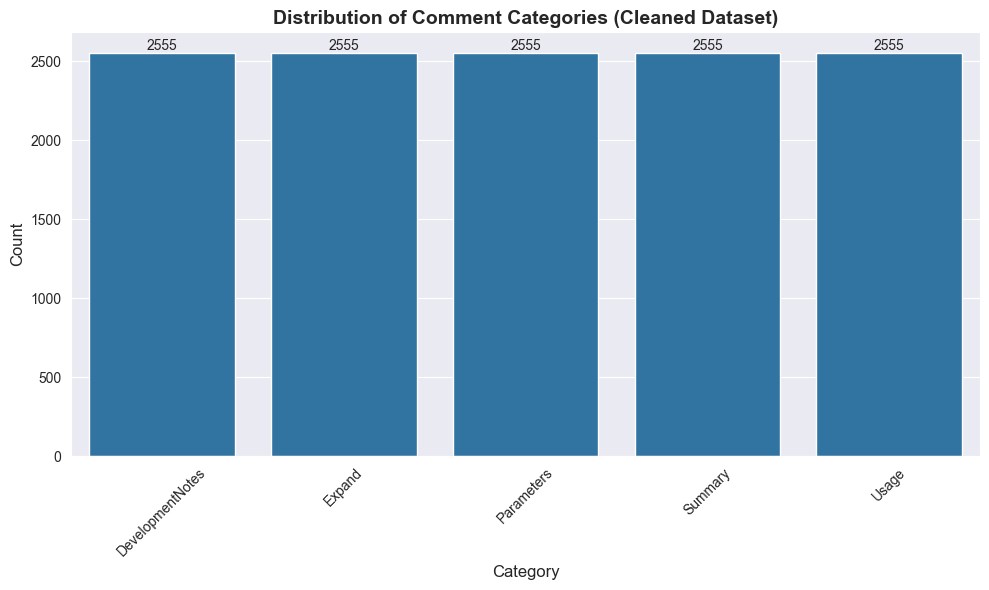

In [17]:
# Visualize category distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='category', order=df_final['category'].value_counts().index)
plt.title('Distribution of Comment Categories (Cleaned Dataset)', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add count labels on bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container)

plt.show()

In [18]:
# Comment length statistics
df_final['comment_length'] = df_final['comment_sentence'].str.len()
df_final['word_count'] = df_final['comment_sentence'].str.split().str.len()

print("\nComment length statistics:")
print(df_final[['comment_length', 'word_count']].describe())


Comment length statistics:
       comment_length  word_count
count    12775.000000  12775.0000
mean        38.702544      6.8000
std         22.505187      4.1422
min          1.000000      1.0000
25%         19.000000      3.0000
50%         37.000000      6.0000
75%         59.000000     10.0000
max        103.000000     26.0000


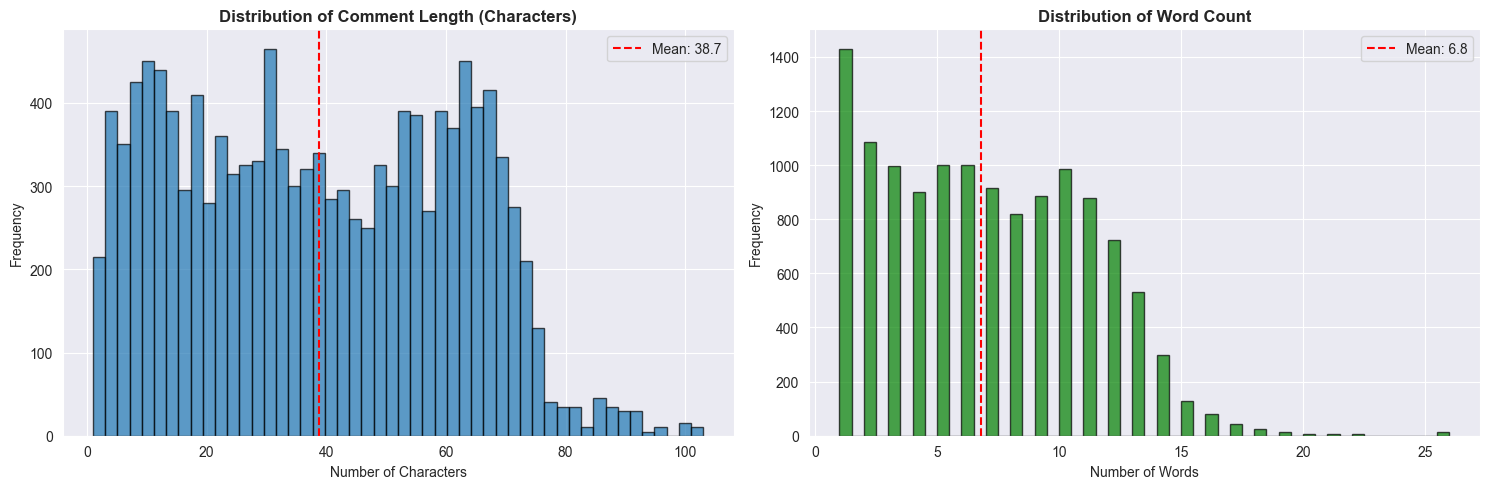

In [19]:
# Visualize comment length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character length distribution
axes[0].hist(df_final['comment_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Comment Length (Characters)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Characters', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].axvline(df_final['comment_length'].mean(), color='red', linestyle='--', label=f'Mean: {df_final["comment_length"].mean():.1f}')
axes[0].legend()

# Word count distribution
axes[1].hist(df_final['word_count'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Distribution of Word Count', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].axvline(df_final['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df_final["word_count"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

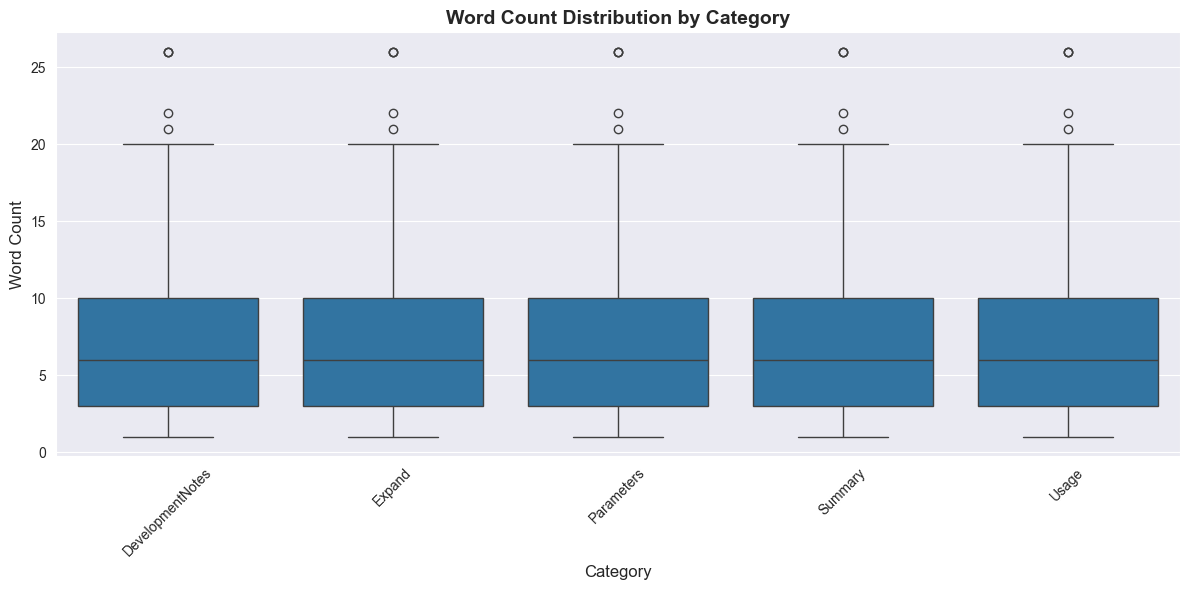

In [20]:
# Word count by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final, x='category', y='word_count')
plt.title('Word Count Distribution by Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Display sample comments from each category
print("\nSample comments from each category:\n")
valid_categories = ['Usage', 'Parameters', 'Expand', 'DevelopmentNotes', 'Summary']
for category in valid_categories:
    print(f"{'='*80}")
    print(f"Category: {category}")
    print(f"{'='*80}")
    category_samples = df_final[df_final['category'] == category]
    if len(category_samples) > 0:
        samples = category_samples.sample(min(3, len(category_samples)))
        for idx, row in samples.iterrows():
            print(f"\nClass: {row['class']}")
            print(f"Comment: {row['comment_sentence'][:200]}..." if len(row['comment_sentence']) > 200 else f"Comment: {row['comment_sentence']}")
    else:
        print("No samples found for this category")
    print()


Sample comments from each category:

Category: Usage

Class: AutoFieldMeta
Comment: create a non integer automatically generated field using column defaults

Class: _FileInFile
Comment: a thin wrapper around an existing file object that

Class: SQLTable
Comment: uses fact that table is reflected by sqlalchemy to

Category: Parameters

Class: TransformerEncoderLayer
Comment: ashish vaswani, noam shazeer, niki parmar, jakob uszkoreit, llion jones, aidan n gomez,

Class: Context_
Comment: additionally there is a meth resolve

Class: BatchNorm1d
Comment: because the batch normalization is done over the c dimension, computing statistics

Category: Expand

Class: EmbeddingBag
Comment: it will be treated as a concatenation of multiple bags sequences .

Class: Adamax
Comment: running averages of gradient and its square

Class: MultiLabelMarginLoss
Comment: reduce bool, optional deprecated see attr reduction .

Category: DevelopmentNotes

Class: VCardStore
Comment: vcards can be looked up dire

## 9. Save Cleaned Dataset

In [22]:
# Drop the temporary length columns before saving
df_to_save = df_final.drop(columns=['comment_length', 'word_count'])

# Save to CSV
output_filename = 'code-comment-classification-cleaned.csv'
df_to_save.to_csv(output_filename, index=False)

print(f"Cleaned dataset saved to: {output_filename}")
print(f"Shape: {df_to_save.shape}")
print(f"Columns: {df_to_save.columns.tolist()}")

Cleaned dataset saved to: code-comment-classification-cleaned.csv
Shape: (12775, 6)
Columns: ['comment_sentence_id', 'class', 'category', 'comment_sentence', 'partition', 'instance_type']


In [23]:
# Final verification
print("\nFinal dataset preview:")
df_to_save.head(10)


Final dataset preview:


,comment_sentence_id,class,category,comment_sentence,partition,instance_type
0,1,AccessMixin,DevelopmentNotes,abstract cbv mixin that gives access mixins the same customizable,1,0
1,1,AccessMixin,Expand,abstract cbv mixin that gives access mixins the same customizable,1,0
2,1,AccessMixin,Parameters,abstract cbv mixin that gives access mixins the same customizable,1,0
3,1,AccessMixin,Summary,abstract cbv mixin that gives access mixins the same customizable,1,1
4,1,AccessMixin,Usage,abstract cbv mixin that gives access mixins the same customizable,0,0
5,2,AccessMixin,DevelopmentNotes,functionality.,1,0
6,2,AccessMixin,Expand,functionality.,1,0
7,2,AccessMixin,Parameters,functionality.,1,0
8,2,AccessMixin,Summary,functionality.,0,1
9,2,AccessMixin,Usage,functionality.,1,0


In [24]:
# Final check: Verify category balance
print("\nFinal category distribution:")
print(df_to_save['category'].value_counts().sort_index())


Final category distribution:
category
DevelopmentNotes    2555
Expand              2555
Parameters          2555
Summary             2555
Usage               2555
Name: count, dtype: int64
